# Setup

In [1]:
#Printing TimeStamp and User Name

import os
 
print("username:" , os.getlogin())
from datetime import date

today = date.today()
print("Today's date:", today)

username: Akansha.Mehta
Today's date: 2022-11-16


In [2]:
import findspark
findspark.init()

In [3]:
#Loading Packages

from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

spark=SparkSession.builder \
.master ("local[*]")\
.appName("part3")\
.getOrCreate()

In [4]:
sc=spark.sparkContext
sqlContext=SQLContext(sc)

C:\Apps\spark-3.3.0-bin-hadoop3\python\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# Loading Data

In [5]:
#Reading file

df=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",";")\
 .csv("XYZ_Bank_Deposit_Data_Classification.csv")
print("There are",df.count(),"rows",len(df.columns),
      "columns" ,"in the data.") 

There are 41188 rows 21 columns in the data.


In [6]:
#Checking data - output

df.toPandas().head(20)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Exploratory Data Analysis

In [7]:
#Renaming columns for better understanding

df = df.withColumnRenamed("emp.var.rate", "employment_variation_rate")\
       .withColumnRenamed("Cons.price.idx", "consumer_price_index")\
       .withColumnRenamed("Cons.conf.idx", "consumer_confidence_index")\
       .withColumnRenamed("euribor3m", "euribor_3_monthrate")\
       .withColumnRenamed("nr.employed", "number_of_employees")\
       .withColumnRenamed("y", "outcome")\
       .withColumnRenamed("default", "credit_default")

In [8]:
#Checking Column DataTypes

df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- credit_default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- employment_variation_rate: double (nullable = true)
 |-- consumer_price_index: double (nullable = true)
 |-- consumer_confidence_index: double (nullable = true)
 |-- euribor_3_monthrate: double (nullable = true)
 |-- number_of_employees: double (nullable = true)
 |-- outcome: string (nullable = true)



In [9]:
#Counting datatypes for all columns 

from collections import Counter
print(Counter((x[1] for x in df.dtypes)))

Counter({'string': 11, 'int': 5, 'double': 5})


In [10]:
#Counting nulls (Method 1)

from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas().head()

,age,job,marital,education,credit_default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,employment_variation_rate,consumer_price_index,consumer_confidence_index,euribor_3_monthrate,number_of_employees,outcome
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
#Method 2 for nulls
Dict_Null = {col:df.filter(df[col].isNull()).count() for col in df.columns}
Dict_Null

{'age': 0,
 'job': 0,
 'marital': 0,
 'education': 0,
 'credit_default': 0,
 'housing': 0,
 'loan': 0,
 'contact': 0,
 'month': 0,
 'day_of_week': 0,
 'duration': 0,
 'campaign': 0,
 'pdays': 0,
 'previous': 0,
 'poutcome': 0,
 'employment_variation_rate': 0,
 'consumer_price_index': 0,
 'consumer_confidence_index': 0,
 'euribor_3_monthrate': 0,
 'number_of_employees': 0,
 'outcome': 0}

In [12]:
#Seeing caridinality

df.toPandas().nunique()

age                            78
job                            12
marital                         4
education                       8
credit_default                  3
housing                         3
loan                            3
contact                         2
month                          10
day_of_week                     5
duration                     1544
campaign                       42
pdays                          27
previous                        8
poutcome                        3
employment_variation_rate      10
consumer_price_index           26
consumer_confidence_index      26
euribor_3_monthrate           316
number_of_employees            11
outcome                         2
dtype: int64

### Categorical Columns and their unique values with distribution

In [13]:
#1. day_of_week
df.select('day_of_week').distinct().collect()

[Row(day_of_week='fri'),
 Row(day_of_week='thu'),
 Row(day_of_week='tue'),
 Row(day_of_week='wed'),
 Row(day_of_week='mon')]

There is no data for Saturday and Sunday.

In [14]:
df.groupby("day_of_week").count().show()

+-----------+-----+
|day_of_week|count|
+-----------+-----+
|        fri| 7827|
|        thu| 8623|
|        tue| 8090|
|        wed| 8134|
|        mon| 8514|
+-----------+-----+



It is spanned almost equally for the given 5 days of week.

In [15]:
#2. month
df.select('month').distinct().collect()

[Row(month='jun'),
 Row(month='aug'),
 Row(month='may'),
 Row(month='mar'),
 Row(month='oct'),
 Row(month='jul'),
 Row(month='nov'),
 Row(month='apr'),
 Row(month='dec'),
 Row(month='sep')]

There is no data for January and Feburary.

In [16]:
df.groupby("month").count().show()

+-----+-----+
|month|count|
+-----+-----+
|  jun| 5318|
|  aug| 6178|
|  may|13769|
|  mar|  546|
|  oct|  718|
|  jul| 7174|
|  nov| 4101|
|  apr| 2632|
|  dec|  182|
|  sep|  570|
+-----+-----+



Months such as September, December, October & March have way lesser datapoints compared to the other months.

In [17]:
#3. marital
df.select('marital').distinct().collect()

[Row(marital='unknown'),
 Row(marital='divorced'),
 Row(marital='married'),
 Row(marital='single')]

In [18]:
df.groupby("marital").count().show()

+--------+-----+
| marital|count|
+--------+-----+
| unknown|   80|
|divorced| 4612|
| married|24928|
|  single|11568|
+--------+-----+



In [19]:
#Very less data points for divorced and only 80 unknowns

In [20]:
#4. education
df.select('education').distinct().collect()

[Row(education='high.school'),
 Row(education='unknown'),
 Row(education='basic.6y'),
 Row(education='professional.course'),
 Row(education='university.degree'),
 Row(education='illiterate'),
 Row(education='basic.4y'),
 Row(education='basic.9y')]

In [21]:
df.groupby("education").count().show()

+-------------------+-----+
|          education|count|
+-------------------+-----+
|        high.school| 9515|
|            unknown| 1731|
|           basic.6y| 2292|
|professional.course| 5243|
|  university.degree|12168|
|         illiterate|   18|
|           basic.4y| 4176|
|           basic.9y| 6045|
+-------------------+-----+



In [22]:
#5. housing
df.select('housing').distinct().collect()

[Row(housing='unknown'), Row(housing='no'), Row(housing='yes')]

In [23]:
df.groupby("housing").count().show()

+-------+-----+
|housing|count|
+-------+-----+
|unknown|  990|
|     no|18622|
|    yes|21576|
+-------+-----+



In [24]:
#Yes and no values for housing with only a few (around 900) unknows

In [25]:
#6. loan
df.select('loan').distinct().collect()

[Row(loan='unknown'), Row(loan='no'), Row(loan='yes')]

In [26]:
df.groupby("loan").count().show()

+-------+-----+
|   loan|count|
+-------+-----+
|unknown|  990|
|     no|33950|
|    yes| 6248|
+-------+-----+



In [27]:
#7. poutcome
df.select('poutcome').distinct().collect()

[Row(poutcome='success'), Row(poutcome='failure'), Row(poutcome='nonexistent')]

In [28]:
df.groupby("poutcome").count().show()

+-----------+-----+
|   poutcome|count|
+-----------+-----+
|    success| 1373|
|    failure| 4252|
|nonexistent|35563|
+-----------+-----+



In [29]:
#8. contact
df.select('contact').distinct().collect()

[Row(contact='cellular'), Row(contact='telephone')]

In [30]:
df.groupby("contact").count().show()

+---------+-----+
|  contact|count|
+---------+-----+
| cellular|26144|
|telephone|15044|
+---------+-----+



In [31]:
#9. credit_default
df.select('credit_default').distinct().collect()

[Row(credit_default='unknown'),
 Row(credit_default='no'),
 Row(credit_default='yes')]

In [32]:
df.groupby("credit_default").count().show()

+--------------+-----+
|credit_default|count|
+--------------+-----+
|       unknown| 8597|
|            no|32588|
|           yes|    3|
+--------------+-----+



In [33]:
#10. job
df.select('job').distinct().collect()

[Row(job='management'),
 Row(job='retired'),
 Row(job='unknown'),
 Row(job='self-employed'),
 Row(job='student'),
 Row(job='blue-collar'),
 Row(job='entrepreneur'),
 Row(job='admin.'),
 Row(job='technician'),
 Row(job='services'),
 Row(job='housemaid'),
 Row(job='unemployed')]

In [34]:
df.groupby("job").count().show()

+-------------+-----+
|          job|count|
+-------------+-----+
|   management| 2924|
|      retired| 1720|
|      unknown|  330|
|self-employed| 1421|
|      student|  875|
|  blue-collar| 9254|
| entrepreneur| 1456|
|       admin.|10422|
|   technician| 6743|
|     services| 3969|
|    housemaid| 1060|
|   unemployed| 1014|
+-------------+-----+



In [35]:
#11. Target variable distribution- outcome
df.select('outcome').distinct().collect()

[Row(outcome='no'), Row(outcome='yes')]

In [36]:
df.groupby("outcome").count().show()

+-------+-----+
|outcome|count|
+-------+-----+
|     no|36548|
|    yes| 4640|
+-------+-----+



### Numeric Columns - Summary Statistics

In [37]:
#Summary Statistics for "int" type columns

numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,41188,40.02406040594348,10.421249980934043,17,98
duration,41188,258.2850101971448,259.27924883646455,0,4918
campaign,41188,2.567592502670681,2.770013542902331,1,56
pdays,41188,962.4754540157328,186.910907344741,0,999
previous,41188,0.17296299893172767,0.49490107983928927,0,7


In [38]:
#Summary Statistics for "double" type columns

numeric_features = [t[0] for t in df.dtypes if t[1] == 'double']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
employment_variation_rate,41188,0.08188550063178966,1.57095974051703,-3.4,1.4
consumer_price_index,41188,93.5756643682899,0.5788400489540823,92.201,94.767
consumer_confidence_index,41188,-40.502600271918276,4.628197856174573,-50.8,-26.9
euribor_3_monthrate,41188,3.621290812858533,1.7344474048512595,0.634,5.045
number_of_employees,41188,5167.035910943957,72.25152766826338,4963.6,5228.1


## Visualization

Since PySpark has no plotting functionality, we have made use matplotlib in Pandas for creating the plots below.

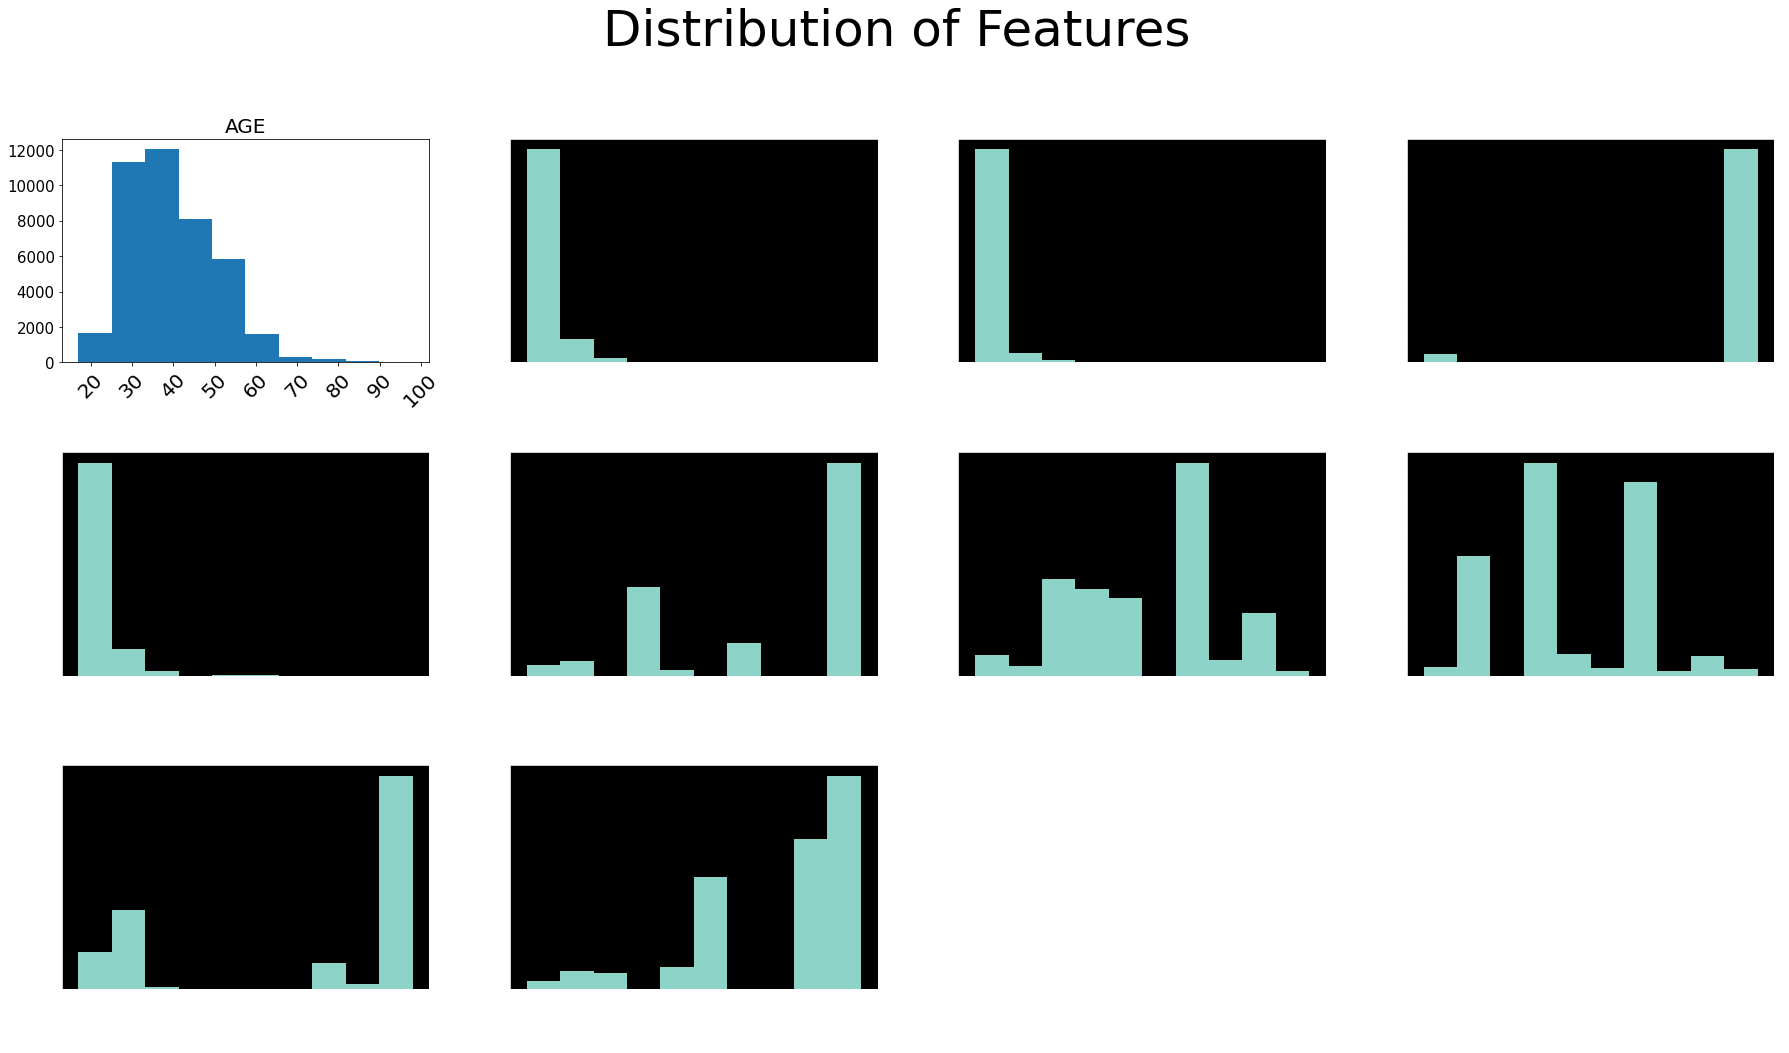

In [39]:
from matplotlib import cm
fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Distribution of Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(df.toPandas().describe().columns, range(1,11)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(df.toPandas()[col])
    plt.style.use('dark_background') 
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

### Correlation

In [40]:
#Creating a dataframe with only numeric columns
numeric_features = [t[0] for t in df.dtypes if t[1] != 'string']
numeric_features_df=df.select(numeric_features)
numeric_features_df.toPandas().head()

,age,duration,campaign,pdays,previous,employment_variation_rate,consumer_price_index,consumer_confidence_index,euribor_3_monthrate,number_of_employees
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0


<AxesSubplot:>

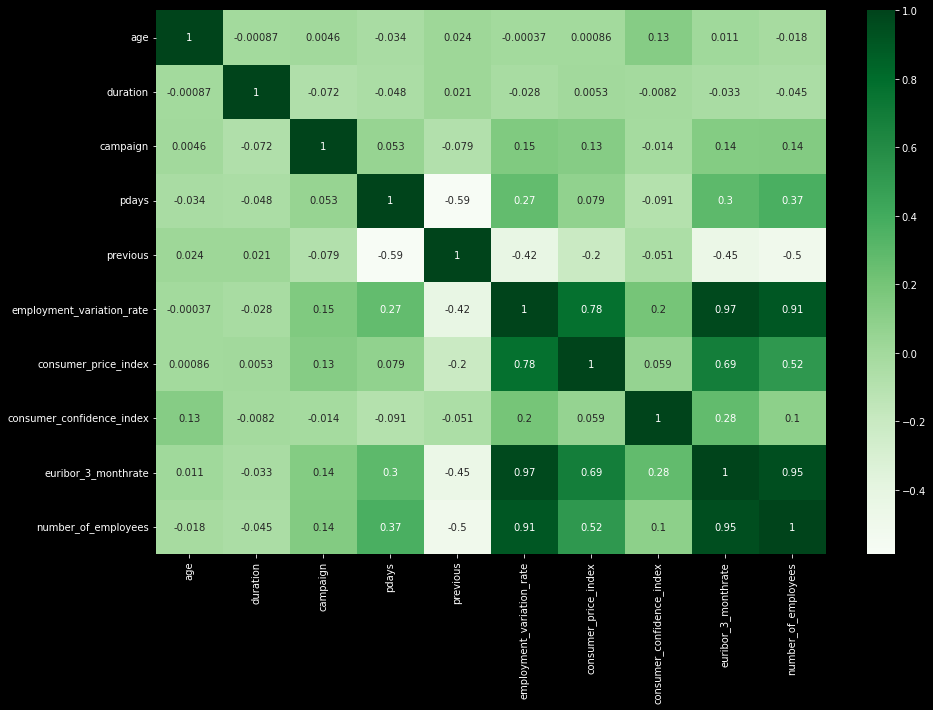

In [41]:
#Pearson Correlation

col_names =numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

import seaborn as sns 
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))  
sns.heatmap(corr_df, 
            xticklabels=corr_df.columns.values,
            yticklabels=corr_df.columns.values,  cmap="Greens", annot=True)

In [42]:
def udf_multiple(age):
    if (age <= 25):
        return 'Under 25'
    elif (age >= 25 and age <= 35):
        return 'Between 25 and 35'
    elif (age > 35 and age < 50):
        return 'Between 36 and 49'
    elif (age >= 50):
        return 'Over 50'
    else: return 'N/A'

education_udf = udf(udf_multiple)
df=df.withColumn("Age_udf", education_udf('Age'))

In [43]:
#In stages we are storing categorical variables which are encoded in on-Hot encoder method and string indexer method
#We are chosing different ways to encode as no one encoding is better than the other. In some variables, one performs better than the other
#In assemblerInputs, we are combining the categorical and numerical columns
#The output from assembler is stored in variable name 'vectorised features' which we further use to deploy our models
#We then standardide the vectors using standard scaler and the output for that is stored in 'features' column


categoricalColumns = ['Age_udf','job','marital','education','credit_default','housing','loan','contact','month','day_of_week','poutcome']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'outcome', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['duration','campaign','pdays','previous','employment_variation_rate','consumer_price_index','consumer_confidence_index','euribor_3_monthrate','number_of_employees']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="vectorized_features", handleInvalid="skip") # use setHandleInvalid("skip")
stages += [assembler]
scaler = StandardScaler(inputCol="vectorized_features", outputCol="features")
stages += [scaler]

In [44]:
cols = df.columns

In [45]:
cols

['age',
 'job',
 'marital',
 'education',
 'credit_default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'employment_variation_rate',
 'consumer_price_index',
 'consumer_confidence_index',
 'euribor_3_monthrate',
 'number_of_employees',
 'outcome',
 'Age_udf']

In [46]:
stages

[StringIndexer_bf03f0f67d82,
 OneHotEncoder_01fc64a423ab,
 StringIndexer_19398ffd132d,
 OneHotEncoder_de3c3e9db786,
 StringIndexer_8ff963518d20,
 OneHotEncoder_3af61c1716b8,
 StringIndexer_d5f7fb43082b,
 OneHotEncoder_981de4351a56,
 StringIndexer_d704dcc63754,
 OneHotEncoder_0c6f99457d79,
 StringIndexer_1e1fa1f41bc3,
 OneHotEncoder_c2271fb58805,
 StringIndexer_b235966c48b6,
 OneHotEncoder_b1bd5f131274,
 StringIndexer_1651839f5b1c,
 OneHotEncoder_70763625d266,
 StringIndexer_9b56ca4e4904,
 OneHotEncoder_97ceef10b760,
 StringIndexer_ce89996bd73b,
 OneHotEncoder_2477c946a561,
 StringIndexer_4b44bfbc83d1,
 OneHotEncoder_f28ddd9e449e,
 StringIndexer_9d13413ee8d6,
 VectorAssembler_2fc62545494f,
 StandardScaler_f2511416c5af]

In [47]:
cols = df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
#selectedCols = ['label', 'features'] + cols
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- credit_default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- employment_variation_rate: double (nullable = true)
 |-- consumer_price_index: double (nullable = true)
 |-- consumer_confidence_index: double (nullable = true)
 |-- euribor_3_monthrate: double (nullable = true)
 |-- number_of_employees: double (nullable = true)
 |-- outcome: string (nullable = true)
 |-- Age_udf: stri

In [48]:
df.toPandas().head()

,label,features,age,job,marital,education,credit_default,housing,loan,contact,...,pdays,previous,poutcome,employment_variation_rate,consumer_price_index,consumer_confidence_index,euribor_3_monthrate,number_of_employees,outcome,Age_udf
0,0.0,"(0.0, 0.0, 2.521170862475759, 0.0, 0.0, 0.0, 0...",56,housemaid,married,basic.4y,no,no,no,telephone,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Over 50
1,0.0,"(0.0, 0.0, 2.521170862475759, 0.0, 0.0, 0.0, 3...",57,services,married,high.school,unknown,no,no,telephone,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Over 50
2,0.0,"(2.0382855256725416, 0.0, 0.0, 0.0, 0.0, 0.0, ...",37,services,married,high.school,no,yes,no,telephone,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Between 36 and 49
3,0.0,"(2.0382855256725416, 0.0, 0.0, 2.3001405778663...",40,admin.,married,basic.6y,no,no,no,telephone,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Between 36 and 49
4,0.0,"(0.0, 0.0, 2.521170862475759, 0.0, 0.0, 0.0, 3...",56,services,married,high.school,no,no,yes,telephone,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Over 50


In [49]:
# Train/Test split
train, test = df.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 32894
Test Dataset Count: 8294


In [50]:
train.groupby("Outcome").count().show()

+-------+-----+
|Outcome|count|
+-------+-----+
|     no|29185|
|    yes| 3709|
+-------+-----+



In [51]:
# Model Training
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=5)
lrModel = lr.fit(train)
predictions = lrModel.transform(test)
#predictions_train = lrModel.transform(train)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"(2.0382855256725416, 0.0, 0.0, 2.3001405778663...","[3.47479241555094, -3.47479241555094]",0.0,"[0.9699619640716175, 0.0300380359283825]"
1,0.0,"(2.0382855256725416, 0.0, 0.0, 2.3001405778663...","[3.431577308630363, -3.431577308630363]",0.0,"[0.9686769616969143, 0.03132303830308569]"
2,0.0,"(2.0382855256725416, 0.0, 0.0, 2.3001405778663...","[3.7737573147506254, -3.7737573147506254]",0.0,"[0.9775499668064876, 0.022450033193512353]"
3,0.0,"(2.0382855256725416, 0.0, 0.0, 2.3001405778663...","[3.87575121791048, -3.87575121791048]",0.0,"[0.979682604737778, 0.020317395262221982]"
4,0.0,"(2.0382855256725416, 0.0, 0.0, 2.3001405778663...","[2.916065852500573, -2.916065852500573]",0.0,"[0.9486349390881106, 0.051365060911889415]"


In [52]:
# Confusion Matrix
# This function prints and plots the confusion matrix.
# Normalization can be applied by setting `normalize=True`.

class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 388  543]
 [ 217 7146]]


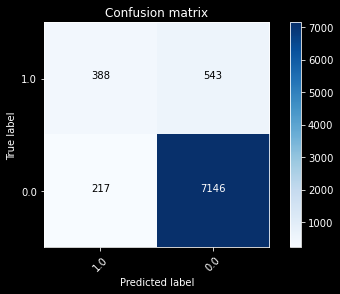

In [53]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [54]:
#Accuracy
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.9083674945743911


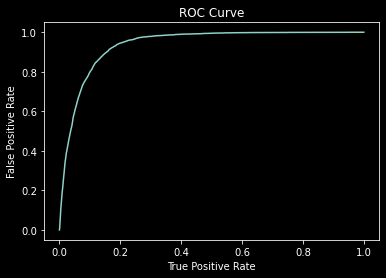

Training set areaUnderROC: 0.9365983487881662


In [55]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [56]:
# Model Evaluation
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9325914415459863


In [57]:
## Cross Validation and Parameter Tuning
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])# regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])# Elastic Net Parameter (Ridge = 0)
             .addGrid(lr.maxIter, [1, 5, 10])#Number of iterations
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, 
                    evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)

In [58]:
## Evaluate Best Model
predictions = cvModel.transform(test)
print('Best Model Test Area Under ROC', evaluator.evaluate(predictions))

Best Model Test Area Under ROC 0.9336848115515884


In [59]:
cvModel.bestModel

LogisticRegressionModel: uid=LogisticRegression_ffa93f3804af, numClasses=2, numFeatures=55

In [60]:
weights = cvModel.bestModel.coefficients
weights = [(float(w),) for w in weights]
weightsDF = sqlContext.createDataFrame(weights, ["Feature Weight"])
weightsDF.toPandas().head(10)

,Feature Weight
0,-0.026672
1,0.000000
2,0.000510
3,0.000000
4,-0.036627
5,0.000000
6,0.000000
7,0.000000
8,0.041266
9,0.000000


In [61]:
best_model=cvModel.bestModel

In [62]:
best_model.explainParams().split("\n")

['aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)',
 'elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.5)',
 'family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)',
 'featuresCol: features column name. (default: features, current: features)',
 'fitIntercept: whether to fit an intercept term. (default: True)',
 'labelCol: label column name. (default: label, current: label)',
 'lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)',
 'lowerBoundsOnIntercepts: The lower bounds on intercepts if fitti

In [63]:
# Decision Trees

In [64]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from sklearn.metrics import confusion_matrix
import pandas as pd 
 

In [65]:
dtc = DecisionTreeClassifier(featuresCol="features", labelCol="label")
dtc = dtc.fit(train)

pred = dtc.transform(test)
pred.toPandas().head(3)

,label,features,age,job,marital,education,credit_default,housing,loan,contact,...,employment_variation_rate,consumer_price_index,consumer_confidence_index,euribor_3_monthrate,number_of_employees,outcome,Age_udf,rawPrediction,probability,prediction
0,0.0,"(2.0382855256725416, 0.0, 0.0, 2.3001405778663...",39,admin.,married,university.degree,no,yes,no,cellular,...,1.4,93.918,-42.7,4.968,5228.1,no,Between 36 and 49,"[22553.0, 171.0]","[0.9924749163879598, 0.007525083612040134]",0.0
1,0.0,"(2.0382855256725416, 0.0, 0.0, 2.3001405778663...",38,admin.,married,university.degree,no,yes,no,cellular,...,1.4,93.918,-42.7,4.962,5228.1,no,Between 36 and 49,"[22553.0, 171.0]","[0.9924749163879598, 0.007525083612040134]",0.0
2,0.0,"(2.0382855256725416, 0.0, 0.0, 2.3001405778663...",46,admin.,married,university.degree,no,yes,no,cellular,...,1.4,93.918,-42.7,4.963,5228.1,no,Between 36 and 49,"[22553.0, 171.0]","[0.9924749163879598, 0.007525083612040134]",0.0


In [66]:
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
acc = evaluator.evaluate(pred)
 
print("Prediction Accuracy: ", acc)
 
y_pred=pred.select("prediction").collect()
y_orig=pred.select("label").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Prediction Accuracy:  0.9099831616319864
Confusion Matrix:
[[7031  332]
 [ 402  529]]


In [67]:
#Prediction accuracy for decision Tree Model is 90.95%

In [68]:
#Random Forest

In [69]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', numTrees=100)
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('*', 'probability').show(5)


+-----+--------------------+---+------+-------+-----------------+--------------+-------+----+--------+-----+-----------+--------+--------+-----+--------+-----------+-------------------------+--------------------+-------------------------+-------------------+-------------------+-------+-----------------+--------------------+--------------------+----------+--------------------+
|label|            features|age|   job|marital|        education|credit_default|housing|loan| contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|employment_variation_rate|consumer_price_index|consumer_confidence_index|euribor_3_monthrate|number_of_employees|outcome|          Age_udf|       rawPrediction|         probability|prediction|         probability|
+-----+--------------------+---+------+-------+-----------------+--------------+-------+----+--------+-----+-----------+--------+--------+-----+--------+-----------+-------------------------+--------------------+-------------------------+----

In [70]:
#showing how the predictions look
predictions.select("label", "prediction").show(10)

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 10 rows



In [71]:
#Evaluate the random forest model

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Accuracy = 0.8740947680732937
Test Error = 0.12590523192670633


In [72]:
#Accuracy for Random forest with 100 trees is 87%

In [73]:
#confusion matrix for random forest classification

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
import pyspark.sql.functions as F

preds_and_labels = predictions.select(['prediction','label']).withColumn('label', F.col('label').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())

C:\Apps\spark-3.3.0-bin-hadoop3\python\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[[7316.   47.]
 [ 763.  168.]]


Confusion matrix, without normalization
[[ 168  763]
 [  47 7316]]


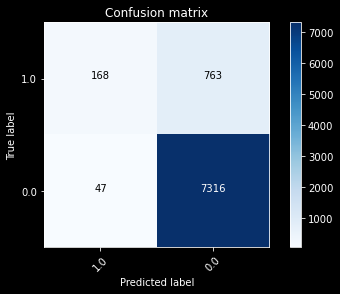

In [74]:
#visualising confusion matrix for random forest
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [75]:
# K means

In [76]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(train)
data_scale_output=data_scale.transform(train)
data_scale_output.toPandas().head(2)

,label,features,age,job,marital,education,credit_default,housing,loan,contact,...,previous,poutcome,employment_variation_rate,consumer_price_index,consumer_confidence_index,euribor_3_monthrate,number_of_employees,outcome,Age_udf,standardized
0,0.0,"(2.0382855256725416, 0.0, 0.0, 2.3001405778663...",44,admin.,married,university.degree,no,yes,no,cellular,...,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no,Between 36 and 49,"(2.036229313864098, 0.0, 0.0, 2.29670727162644..."
1,0.0,"(2.0382855256725416, 0.0, 0.0, 2.3001405778663...",44,admin.,married,university.degree,no,yes,no,cellular,...,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no,Between 36 and 49,"(2.036229313864098, 0.0, 0.0, 2.29670727162644..."


In [77]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.20502898666544395
Silhouette Score: 0.08846522558249388
Silhouette Score: 0.09847901041394949
Silhouette Score: 0.06561096405979465
Silhouette Score: 0.0930059590152895
Silhouette Score: 0.10378613948572174
Silhouette Score: 0.10304139368444726
Silhouette Score: 0.1232780122216954
